<a href="https://colab.research.google.com/github/dTenebrae/nlp/blob/main/lesson7/hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output

Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации
2. Рассмотреть 2-а варианта сеточек
2.1 Инициализировать tf.keras.layers.Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/
2.2 Инициализировать слой tf.keras.layers.Embedding по умолчанию (ну то есть вам ничего не делать с весами)

Сравнить две архитектуры с предобученными весами и когда tf.keras.layers.Embedding обучается сразу со всей сеточкой, что получилось лучше

___

In [2]:
!pip install stop-words
!pip install pymorphy2
clear_output()

In [3]:
import pandas as pd
import numpy as np

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
TRAIN = "drive/MyDrive/csv/nlp_hw7_data/train.csv"
TEST = "drive/MyDrive/csv/nlp_hw7_data/test.csv"
VAL = "drive/MyDrive/csv/nlp_hw7_data/val.csv"

df_train = pd.read_csv(TRAIN)
df_test = pd.read_csv(TEST)
df_val = pd.read_csv(VAL)

In [6]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [7]:
df_test.head()

,id,text
0,204150,Тектоника и рельеф-самое ужасное в мире мучение(
1,204151,"Ходили запускать шар желаний, но у нас не полу..."
2,204152,"Хочу лето только ради того, что бы направить н..."
3,204153,RT @RonyLiss: @colf_ne блин((\nа я шипперила Ф...
4,204154,"RT @anna_romt: @ZADROT_PO_IGRAM блин,каждое во..."


In [8]:
df_val.head()

,id,text,class
0,181467,RT @TukvaSociopat: Максимальный репост! ))) #є...,1
1,181468,чтоб у меня з.п. ежегодно индексировали на инд...,0
2,181469,@chilyandlime нехуя мне не хорошо !!! :((((,0
3,181470,"@inafish нее , когда ногами ахахах когда?ахаха...",0
4,181471,"Хочу сделать как лучше, а получаю как всегда. :(",0


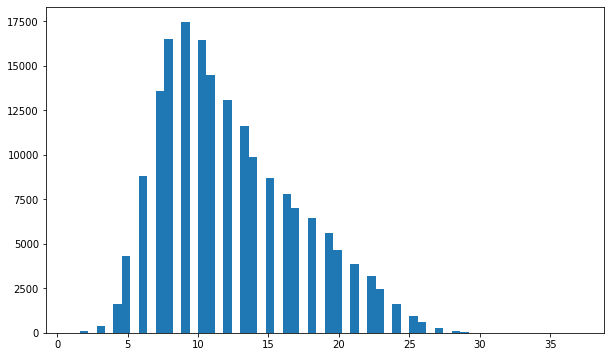

In [9]:
plt.figure(figsize=(10, 6))
_, _, hist = plt.hist(df_train["text"].apply(lambda x: len(x.split())), bins=60)
hist;

In [10]:
# посмотрим максимальные длины выражений в каждом из датсетов
train_len = df_train["text"].apply(lambda x: len(x.split())).max()
test_len = df_test["text"].apply(lambda x: len(x.split())).max()
val_len = df_val["text"].apply(lambda x: len(x.split())).max()
train_len, test_len, val_len

(37, 40, 32)

In [11]:
max_words = 500_000
max_len = 40
num_classes = 1

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

In [12]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [13]:
train_corpus = " ".join(df_train["text"])
train_corpus = train_corpus.lower()

In [14]:
tokens = word_tokenize(train_corpus)

In [15]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [16]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [17]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [18]:
i = 10
for key, val in vocabulary.items():
    print(f"{key}: {val}")
    i -= 1
    if i <= 0:
        break

rt: 1
d: 2
хотеть: 3
знать: 4
ян: 5
мочь: 6
новый: 7
любить: 8
завтра: 9
мой: 10


In [19]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [20]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["text"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["text"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["text"]], dtype=np.int32)

In [21]:
x_train.shape, x_test.shape, x_val.shape

((181467, 40), (22684, 40), (22683, 40))

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D, MaxPooling1D, Flatten, TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [23]:
num_classes = 2
y_train = keras.utils.to_categorical(df_train["class"], num_classes)
y_val = keras.utils.to_categorical(df_val["class"], num_classes)

In [24]:
# embedding_layer = Embedding(len(word_index) + 1,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             input_length=max_len,
#                             trainable=False)
embedding_layer = Embedding(input_dim=max_words, output_dim=128, input_length=max_len)

In [25]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu', data_format='channels_first')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', data_format='channels_first')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', data_format='channels_first')(x)
x = MaxPooling1D(35)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(num_classes, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 128)           64000000  
                                                                 
 conv1d (Conv1D)             (None, 128, 124)          25728     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 124)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 120)          16128     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 120)          0         
 1D)                                                         

In [27]:
early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/20
284/284 [==============================] - 27s 36ms/step - loss: 0.5525 - acc: 0.6974 - val_loss: 0.4914 - val_acc: 0.7515
Epoch 2/20
284/284 [==============================] - 9s 33ms/step - loss: 0.2555 - acc: 0.8957 - val_loss: 0.5641 - val_acc: 0.7401
Epoch 3/20
284/284 [==============================] - 9s 33ms/step - loss: 0.0363 - acc: 0.9875 - val_loss: 0.8860 - val_acc: 0.7282
Epoch 4/20
284/284 [==============================] - 9s 33ms/step - loss: 0.0046 - acc: 0.9985 - val_loss: 1.4921 - val_acc: 0.7354


In [28]:
score = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=False)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.5075806379318237
Val accuracy: 0.7411717772483826


## Pretrained embeddings

In [29]:
!pip install navec

In [30]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

--2021-11-15 15:46:57--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  15.9MB/s    in 3.2s    

2021-11-15 15:47:01 (15.9 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [31]:
from navec import Navec

path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)

In [33]:
vectorizer = TextVectorization(max_tokens=max_words, output_sequence_length=max_len)
text_ds = tf.data.Dataset.from_tensor_slices(df_train["text").batch(128)
vectorizer.adapt(text_ds)

In [34]:
len(vectorizer.get_vocabulary())

304638

In [35]:
vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'rt', 'd', 'хотеть', 'знать', 'ян', 'мочь', 'новый', 'любить']

In [36]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [37]:
test = ['хотеть', 'знать', 'ян', 'мочь', 'новый', 'любить']
[word_index[w] for w in test]

[4, 5, 6, 7, 8, 9]

In [38]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = navec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 39150 words (265488 misses)


In [45]:
print(f"{(misses / num_tokens) * 100:.2f}% пропущено")

87.15% пропущено


In [39]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [40]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu', data_format='channels_first')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', data_format='channels_first')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', data_format='channels_first')(x)
x = MaxPooling1D(35)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(num_classes, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['acc'])

In [41]:
x_train = vectorizer(np.array(df_train["text"])).numpy()

In [42]:
early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/20
319/319 [==============================] - 12s 33ms/step - loss: 0.6335 - acc: 0.6218 - val_loss: 0.6020 - val_acc: 0.6667
Epoch 2/20
319/319 [==============================] - 10s 32ms/step - loss: 0.5870 - acc: 0.6775 - val_loss: 0.5903 - val_acc: 0.6772
Epoch 3/20
319/319 [==============================] - 10s 32ms/step - loss: 0.5729 - acc: 0.6898 - val_loss: 0.5887 - val_acc: 0.6768
Epoch 4/20
319/319 [==============================] - 10s 31ms/step - loss: 0.5632 - acc: 0.6964 - val_loss: 0.5810 - val_acc: 0.6810
Epoch 5/20
319/319 [==============================] - 10s 31ms/step - loss: 0.5538 - acc: 0.7039 - val_loss: 0.5793 - val_acc: 0.6823
Epoch 6/20
319/319 [==============================] - 10s 31ms/step - loss: 0.5449 - acc: 0.7110 - val_loss: 0.5796 - val_acc: 0.6827
Epoch 7/20
319/319 [==============================] - 10s 31ms/step - loss: 0.5371 - acc: 0.7163 - val_loss: 0.5808 - val_acc: 0.6844
Epoch 8/20
319/319 [==============================] - 10s 31ms

In [43]:
score = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=False)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.704058825969696
Val accuracy: 0.5080456733703613


**В нашем случае метрика получилась сильно хуже, так как в предобученых эмбеддингах большой процент (87%) пропущеных слов**